<a href="https://colab.research.google.com/github/popudrak/DSC-PJATK/blob/main/Product_recomendation_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831125 sha256=74582c88e8d943dc8eaa105cfb0686a98c9fe844220e74ae3151b6814c40ba83
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [ ]:
import pandas as pd
import numpy as np
import json
import os

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
item_metadata = pd.read_csv("item_metadata_filtered.csv")

with open("id_mappings.json", "r") as f:
    id_mappings = json.load(f)

user_mapping = id_mappings["user_mapping"]
item_mapping = id_mappings["item_mapping"]
user_reverse_mapping = id_mappings["user_reverse_mapping"]
item_reverse_mapping = id_mappings["item_reverse_mapping"]

In [ ]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Item metadata shape:", item_metadata.shape)

print("\nTrain head:")
print(train.head())

print("\nTest head:")
print(test.head())

print("\nItem metadata head:")
print(item_metadata.head())

Train shape: (2543146, 4)
Test shape: (412461, 2)
Item metadata shape: (77833, 15)

Train head:
   user_id  item_id  rating      timestamp
0        0     7314     5.0  1353612262000
1        0    15493     5.0  1370653034000
2        0    18817     4.0  1373668644000
3        0    18251     4.0  1373669469000
4        0    16199     1.0  1375136041000

Test head:
   user_id  predictions
0        0            0
1        1            0
2        3            0
3        5            0
4        6            0

Item metadata head:
  parent_asin main_category  \
0  B07WFSQXL5    All Beauty   
1  B08BV6F6BC    All Beauty   
2  B07Z818MLY    All Beauty   
3  B071DY8Z4B    All Beauty   
4  B0BTLTVR1X    All Beauty   

                                               title  average_rating  \
0  PPY Eyelash Growth Serum – Natural Ingredients...             3.9   
1  Wixar Natural Sea Moss Soap - (2 PACK) - Laven...             4.4   
2  7 Packs Deep Wave Crochet Hair 22 Inch Deep wa...             3

In [ ]:
train['datetime'] = pd.to_datetime(train['timestamp'], unit='ms')

Liczba użytkowników: 868218
Liczba produktów: 76747


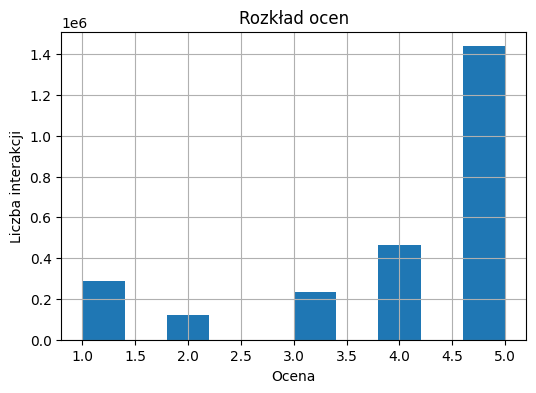

AVG interakcji na użytkownika: 2.93
Mediana liczby interakcji: 2.0


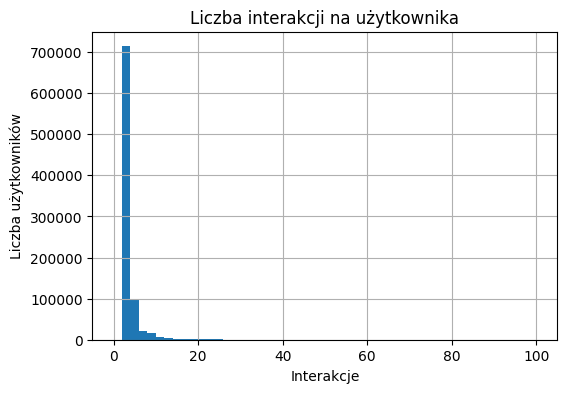

AVG interakcji na produkt: 33.14
Mediana liczby interakcji: 3.0


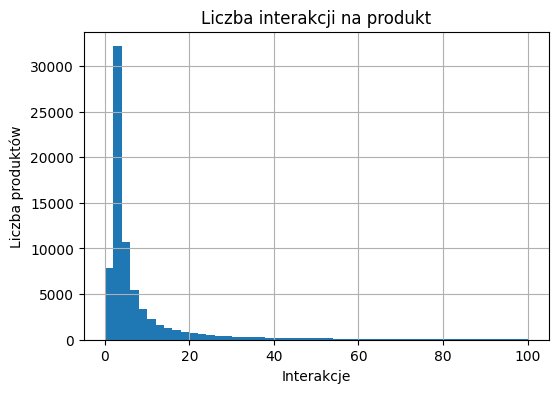

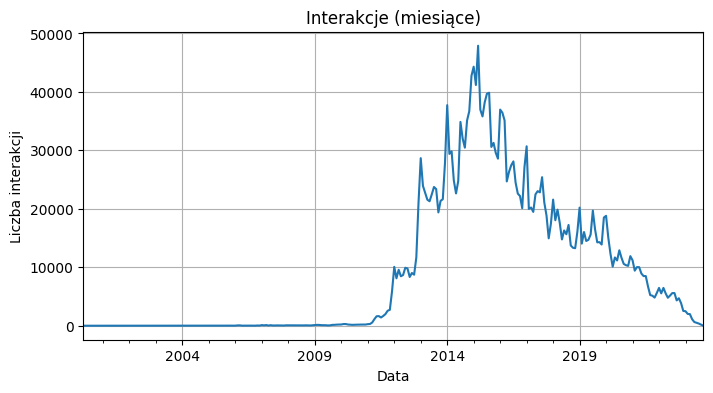

In [ ]:
import matplotlib.pyplot as plt

n_users = train['user_id'].nunique()
n_items = train['item_id'].nunique()

print("Liczba użytkowników:", n_users)
print("Liczba produktów:", n_items)

plt.figure(figsize=(6, 4))
train['rating'].hist(bins=10)
plt.title("Rozkład ocen")
plt.xlabel("Ocena")
plt.ylabel("Liczba interakcji")
plt.grid(True)
plt.show()

user_activity = train.groupby('user_id')['item_id'].count()
print("AVG interakcji na użytkownika:", round(user_activity.mean(), 2))
print("Mediana liczby interakcji:", user_activity.median())

plt.figure(figsize=(6, 4))
user_activity.hist(bins=50, range=(0, 100))
plt.title("Liczba interakcji na użytkownika")
plt.xlabel("Interakcje")
plt.ylabel("Liczba użytkowników")
plt.grid(True)
plt.show()

item_popularity = train.groupby('item_id')['user_id'].count()
print("AVG interakcji na produkt:", round(item_popularity.mean(), 2))
print("Mediana liczby interakcji:", item_popularity.median())

plt.figure(figsize=(6, 4))
item_popularity.hist(bins=50, range=(0, 100))
plt.title("Liczba interakcji na produkt")
plt.xlabel("Interakcje")
plt.ylabel("Liczba produktów")
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 4))
train['datetime'].dt.to_period('M').value_counts().sort_index().plot()
plt.title("Interakcje (miesiące)")
plt.xlabel("Data")
plt.ylabel("Liczba interakcji")
plt.grid(True)
plt.show()

Top 10

In [ ]:
popular_items = train['item_id'].value_counts().head(10).index.tolist()

print("Top 10 (item_id):", popular_items)

test['predictions'] = [' '.join(map(str, popular_items))] * len(test)

test[['user_id', 'predictions']].to_csv('submission_popular.csv', index=False)

Top 10 (item_id): [20832, 12595, 12372, 6864, 33154, 13451, 7030, 24931, 18550, 12104]


In [ ]:
from lightfm import LightFM
from lightfm.data import Dataset
from scipy.sparse import coo_matrix
import numpy as np
import tqdm
dataset = Dataset()
dataset.fit(train['user_id'], train['item_id'])

(interactions, weights) = dataset.build_interactions(
    [(row['user_id'], row['item_id'], row['rating']) for _, row in train.iterrows()]
)

print("Wymiary macierzy interakcji (użytkownicy x produkty):", interactions.shape)

Wymiary macierzy interakcji (użytkownicy x produkty): (868218, 76747)


In [ ]:
user_ids = train['user_id'].unique()
item_ids = train['item_id'].unique()

user_id_map = {uid: i for i, uid in enumerate(user_ids)}
item_id_map = {iid: i for i, iid in enumerate(item_ids)}

user_id_reverse_map = {i: uid for uid, i in user_id_map.items()}
item_id_reverse_map = {i: iid for iid, i in item_id_map.items()}

In [ ]:
train['user_idx'] = train['user_id'].map(user_id_map)
train['item_idx'] = train['item_id'].map(item_id_map)

from scipy.sparse import coo_matrix

interactions = coo_matrix(
    (train['rating'], (train['user_idx'], train['item_idx'])),
    shape=(len(user_id_map), len(item_id_map))
).tocsr()

In [ ]:
model = LightFM(loss='warp', no_components=32)
model.fit(interactions, epochs=10, num_threads=4)

In [ ]:
import tqdm

all_items = np.arange(interactions.shape[1])
user_seen_items = train.groupby('user_id')['item_id'].apply(set).to_dict()

submission = []

for uid in tqdm.tqdm(test['user_id'].values):
    if uid not in user_id_map:
        continue

    uidx = user_id_map[uid]
    seen = set(train[train['user_idx'] == uidx]['item_idx'].values)

    item_indices = np.arange(len(item_id_map))
    user_ids = np.repeat(uidx, len(item_indices))
    scores = model.predict(user_ids, item_indices)

    top_idxs = [i for i in np.argsort(-scores) if i not in seen][:10]
    top_items = [item_id_reverse_map[i] for i in top_idxs]

    submission.append((uid, ' '.join(map(str, top_items))))

submission_df = pd.DataFrame(submission, columns=['user_id', 'predictions'])
submission_df.to_csv("submission_lightfm_remapped.csv", index=False)

print("Gotowe — plik zapisany.")

100%|██████████| 412461/412461 [3:48:15<00:00, 30.12it/s]


Gotowe — plik zapisany.


##Dostrajanie modelu

In [ ]:
model = LightFM(loss='warp', no_components=64)
model.fit(interactions, epochs=30, num_threads=4)

In [ ]:
all_item_indices = np.arange(len(item_id_map))

user_seen_items = train.groupby('user_idx')['item_idx'].apply(set).to_dict()

submission = []

for uid in tqdm.tqdm(test['user_id'].values):
    if uid not in user_id_map:
        continue

    uidx = user_id_map[uid]
    seen = set(train[train['user_idx'] == uidx]['item_idx'].values)

    item_indices = np.arange(len(item_id_map))
    user_ids = np.repeat(uidx, len(item_indices))
    scores = model.predict(user_ids, item_indices)

    top_idxs = [i for i in np.argsort(-scores) if i not in seen][:10]
    top_items = [item_id_reverse_map[i] for i in top_idxs]

    submission.append((uid, ' '.join(map(str, top_items))))

submission_df = pd.DataFrame(submission, columns=['user_id', 'predictions'])
submission_df.to_csv("submission_lightfm_tuned.csv", index=False)

print("Gotowe — plik zapisany")

100%|██████████| 412461/412461 [5:01:12<00:00, 22.82it/s]


Gotowe — plik zapisany


## Dodanie cech produktów (item_features) do LightFM

In [ ]:
from lightfm import LightFM
from lightfm.data import Dataset
from scipy.sparse import coo_matrix
import numpy as np
from tqdm import tqdm

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
metadata = pd.read_csv("item_metadata_filtered.csv")

user_ids = train['user_id'].unique()
item_ids = train['item_id'].unique()

user_id_map = {uid: i for i, uid in enumerate(user_ids)}
item_id_map = {iid: i for i, iid in enumerate(item_ids)}
user_id_reverse_map = {i: uid for uid, i in user_id_map.items()}
item_id_reverse_map = {i: iid for iid, i in item_id_map.items()}

train['user_idx'] = train['user_id'].map(user_id_map)
train['item_idx'] = train['item_id'].map(item_id_map)

In [ ]:
metadata['item_idx'] = metadata['parent_asin'].map(item_id_map)
metadata = metadata[metadata['item_idx'].notnull()]
metadata['item_idx'] = metadata['item_idx'].astype(int)

metadata['main_category'] = metadata['main_category'].fillna("Unknown")
metadata['has_images'] = metadata['has_images'].fillna(False)

In [ ]:
unique_categories = metadata['main_category'].unique().tolist()
item_features_list = ['category:' + cat for cat in unique_categories] + ['has_images']

dataset = Dataset()
dataset.fit(users=user_ids, items=item_ids)
dataset.fit_partial(items=item_ids, item_features=item_features_list)

(interactions, _) = dataset.build_interactions(
    [(row['user_id'], row['item_id'], row['rating']) for _, row in train.iterrows()]
)

def build_item_features(metadata):
    features = []
    for _, row in metadata.iterrows():
        feats = ['category:' + row['main_category']]
        if row['has_images']:
            feats.append('has_images')
        features.append((row['parent_asin'], feats))
    return features

item_features = dataset.build_item_features(build_item_features(metadata))

In [ ]:
model = LightFM(loss='warp', no_components=128)
model.fit(interactions, item_features=item_features, epochs=50, num_threads=8)

In [ ]:
submission = []

train['user_idx'] = train['user_id'].map(user_id_map)
train['item_idx'] = train['item_id'].map(item_id_map)
user_seen_items = train.groupby('user_idx')['item_idx'].apply(set).to_dict()

all_item_indices = np.arange(len(item_id_map))

for uid in tqdm(test['user_id'].values):
    if uid not in user_id_map:
        continue

    uidx = user_id_map[uid]
    seen = user_seen_items.get(uidx, set())
    user_ids = np.repeat(uidx, len(all_item_indices))

    scores = model.predict(user_ids, all_item_indices, item_features=item_features)
    top_idxs = [i for i in np.argsort(-scores) if i not in seen][:10]
    top_items = [item_id_reverse_map[i] for i in top_idxs]

    submission.append((uid, ' '.join(map(str, top_items))))

submission_df = pd.DataFrame(submission, columns=['user_id', 'predictions'])
submission_df.to_csv("submission_lightfm_features.csv", index=False)

  2%|▏         | 7108/412461 [06:22<6:03:33, 18.58it/s]


KeyboardInterrupt: 